In [1]:
# The import statements
import math
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
# Constants for configuration
DB_PATH = './simulation-series/gnutella-series.db'
DB_PATH_comm_goss = './simulation-series/gnutella-comm-goss.db'
TABLE_SUMMARIES = 'SUMMARIES'
TABLE_AVERAGED_RESULTS = 'AVERAGED_RESULTS'

In [3]:
# Establish a connection to the SQLite database
conn = sqlite3.connect(DB_PATH)

# Query to retrieve the data from the database
query = f"SELECT * FROM {TABLE_SUMMARIES}"

# Read the data into a pandas DataFrame
dataframe = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the first few rows of the DataFrame
dataframe.head()

,timestamp,algorithm,prior_partner_factor,assortativity,averageAuthorityScore,averageBetweennessCentrality,averageClosenessCentrality,averageCommunitySize,averageDegreeCentrality,averageEccentricity,...,transitivity,graphType,objectStoragePath,numRounds,factor,weighting_param_a,averageNeighborsDegree,averageNodeDegree,stdevNeighborsDegree,stdevnodeDegree
0,2023-08-28-12-37-22,community_probabilities_complex_memory,0.5,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-cp-cm-63cd3570-bdc4-4bae-8a2b-...,14.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-08-28-13-00-47,community_probabilities_complex_memory,0.5,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-cp-cm-63cd3570-bdc4-4bae-8a2b-...,17.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-08-28-12-39-48,community_probabilities_complex_memory,0.5,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-cp-cm-63cd3570-bdc4-4bae-8a2b-...,15.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-08-28-12-42-18,community_probabilities_complex_memory,0.5,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-cp-cm-63cd3570-bdc4-4bae-8a2b-...,16.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-08-28-12-44-33,community_probabilities_complex_memory,0.5,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-cp-cm-63cd3570-bdc4-4bae-8a2b-...,14.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Establish a connection to the additional SQLite database
conn_adv = sqlite3.connect(DB_PATH_comm_goss)

# Query to retrieve the data from the additional database
query_adv = f"SELECT * FROM {TABLE_SUMMARIES}"

# Read the data from the additional database into a pandas DataFrame
dataframe_adv = pd.read_sql_query(query_adv, conn_adv)

# Close the additional database connection
conn_adv.close()

# Concatenate or merge the dataframes vertically
dataframe = pd.concat([dataframe, dataframe_adv], ignore_index=True)

# Display the first few rows of the combined DataFrame
dataframe.head()

,timestamp,algorithm,prior_partner_factor,assortativity,averageAuthorityScore,averageBetweennessCentrality,averageClosenessCentrality,averageCommunitySize,averageDegreeCentrality,averageEccentricity,...,transitivity,graphType,objectStoragePath,numRounds,factor,weighting_param_a,averageNeighborsDegree,averageNodeDegree,stdevNeighborsDegree,stdevnodeDegree
0,2023-08-28-12-37-22,community_probabilities_complex_memory,0.5,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-cp-cm-63cd3570-bdc4-4bae-8a2b-...,14.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-08-28-13-00-47,community_probabilities_complex_memory,0.5,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-cp-cm-63cd3570-bdc4-4bae-8a2b-...,17.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-08-28-12-39-48,community_probabilities_complex_memory,0.5,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-cp-cm-63cd3570-bdc4-4bae-8a2b-...,15.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-08-28-12-42-18,community_probabilities_complex_memory,0.5,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-cp-cm-63cd3570-bdc4-4bae-8a2b-...,16.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-08-28-12-44-33,community_probabilities_complex_memory,0.5,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-cp-cm-63cd3570-bdc4-4bae-8a2b-...,14.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Group the DataFrame by 'algorithm' and 'factor'
group_by_alg = dataframe.groupby('algorithm')

# Create a dictionary to store the smaller DataFrames
alg_df = {}

# Iterate over the groups and store them in the dictionary
for algorithm, group_df in group_by_alg:
    alg_df[algorithm] = group_df

alg_df.keys()

dict_keys(['betweenness_weighted', 'betweenness_weighted_complex_memory', 'community_based', 'community_probabilities', 'community_probabilities_complex_memory', 'default', 'weighted_factor'])

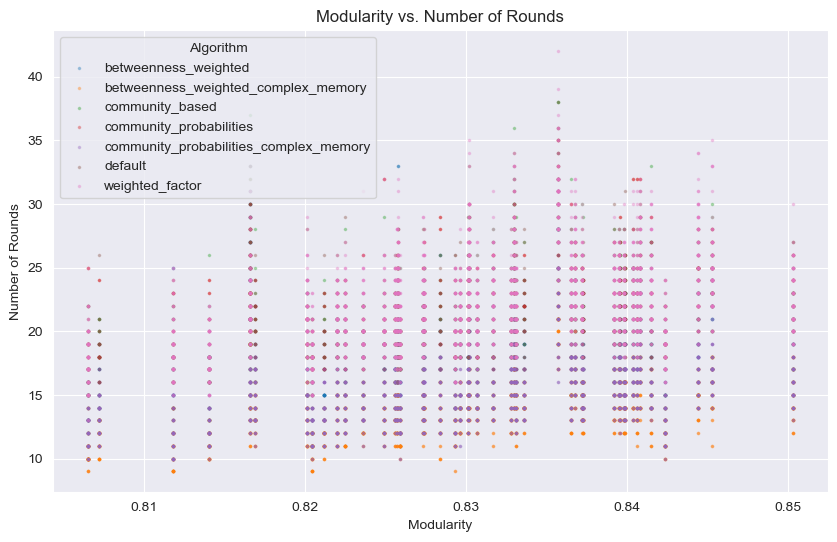

In [6]:
# Create a pretty plot using matplotlib
plt.figure(figsize=(10, 6))

for alg, df in alg_df.items():
    plt.scatter(df['modularity'], df['numRounds'], label=alg, alpha=0.3, marker='.', s=10)

plt.xlabel('Modularity')
plt.ylabel('Number of Rounds')
plt.title('Modularity vs. Number of Rounds')
plt.legend(title='Algorithm')

# Show the plot
plt.show()

In [7]:
# Group the DataFrame by 'factor'
group_by_factor = dataframe[dataframe['algorithm'] == 'weighted_factor'].groupby('factor')

# Create a dictionary to store the smaller DataFrames
grouped_df = {}

# Iterate over the groups and store them in the dictionary
for factor, group_df in group_by_factor:
    factor_key = f'{factor}'
    grouped_df[factor_key] = group_df
    print(f'Dataframe for weighted with factor {factor_key} has {len(group_df)} entries')

df_default = dataframe[dataframe['algorithm'] == 'default']
print(f'Dataframe for default has {len(df_default)} entries')

df_cp = dataframe[dataframe['algorithm'] == 'community_probabilities']
print(f'Dataframe for community_probabilities has {len(df_cp)} entries')

#df_cp_cm = dataframe[dataframe['algorithm'] == 'community_probabilities_complex_memory']
#print(f'Dataframe for community_probabilities_complex_memory has {len(df_cp_cm)} entries')

df_bn = dataframe[dataframe['algorithm'] == 'betweenness_weighted']
print(f'Dataframe for betweenness_weighted has {len(df_bn)} entries')

df_cb = dataframe[dataframe['algorithm'] == 'community_based']
print(f'Dataframe for community_based has {len(df_cb)} entries')

grouped_df.keys()

Dataframe for weighted with factor 1.25 has 400 entries
Dataframe for weighted with factor 1.5 has 400 entries
Dataframe for weighted with factor 1.75 has 400 entries
Dataframe for weighted with factor 2.0 has 400 entries
Dataframe for weighted with factor 2.25 has 400 entries
Dataframe for weighted with factor 2.5 has 400 entries
Dataframe for weighted with factor 2.75 has 400 entries
Dataframe for weighted with factor 3.0 has 400 entries
Dataframe for default has 1000 entries
Dataframe for community_probabilities has 1000 entries
Dataframe for betweenness_weighted has 1000 entries
Dataframe for community_based has 500 entries


dict_keys(['1.25', '1.5', '1.75', '2.0', '2.25', '2.5', '2.75', '3.0'])

In [8]:
grouped_df['1.25']

,timestamp,algorithm,prior_partner_factor,assortativity,averageAuthorityScore,averageBetweennessCentrality,averageClosenessCentrality,averageCommunitySize,averageDegreeCentrality,averageEccentricity,...,transitivity,graphType,objectStoragePath,numRounds,factor,weighting_param_a,averageNeighborsDegree,averageNodeDegree,stdevNeighborsDegree,stdevnodeDegree
9000,2023-07-16-14-12-04,weighted_factor,NaN,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,19.0,1.25,NaN,NaN,NaN,NaN,NaN
9001,2023-07-16-14-39-18,weighted_factor,NaN,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,19.0,1.25,NaN,NaN,NaN,NaN,NaN
9002,2023-07-16-14-14-50,weighted_factor,NaN,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,18.0,1.25,NaN,NaN,NaN,NaN,NaN
9003,2023-07-16-14-17-36,weighted_factor,NaN,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,18.0,1.25,NaN,NaN,NaN,NaN,NaN
9004,2023-07-16-14-20-52,weighted_factor,NaN,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,...,0.0077,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,21.0,1.25,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12125,2023-07-24-06-09-46,weighted_factor,NaN,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,...,0.0046,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,22.0,1.25,NaN,NaN,NaN,NaN,NaN
12126,2023-07-24-06-12-57,weighted_factor,NaN,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,...,0.0046,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,18.0,1.25,NaN,NaN,NaN,NaN,NaN
12127,2023-07-24-06-16-00,weighted_factor,NaN,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,...,0.0046,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,20.0,1.25,NaN,NaN,NaN,NaN,NaN
12128,2023-07-24-06-19-06,weighted_factor,NaN,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,...,0.0046,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,20.0,1.25,NaN,NaN,NaN,NaN,NaN


In [9]:
default_means = df_default['numRounds'].mean()
default_means

22.228

In [10]:
weighted_factor_means = dataframe[dataframe['algorithm'] == 'weighted_factor'].groupby('factor')['numRounds'].mean()
weighted_factor_means

factor
1.25    21.8750
1.50    21.8875
1.75    21.9300
2.00    21.9650
2.25    22.2100
2.50    22.2225
2.75    22.5950
3.00    22.4525
Name: numRounds, dtype: float64

In [11]:
algorithm_means = weighted_factor_means.copy()
algorithm_means[1.0] = default_means
algorithm_means

factor
1.25    21.8750
1.50    21.8875
1.75    21.9300
2.00    21.9650
2.25    22.2100
2.50    22.2225
2.75    22.5950
3.00    22.4525
1.00    22.2280
Name: numRounds, dtype: float64

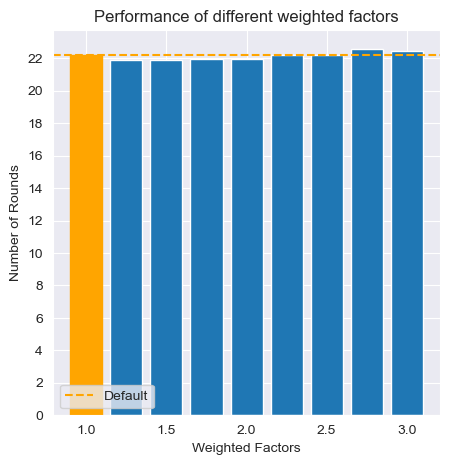

In [12]:
factors = algorithm_means.index
numRounds = algorithm_means.values

plt.figure(figsize=(5, 5))
bar_width = 0.2

# Iterate through the factors and numRounds to color the bars differently
bars = plt.bar(factors, numRounds, width=bar_width)
for i, factor in enumerate(factors):
    if factor == 1.0:
        bars[i].set_color('orange')  # Color the bar with factor 1.0 differently

# Draw a horizontal line at the value of factor 1.0
plt.axhline(y=numRounds[factors == 1.0][0], color='orange', linestyle='--', label='Default')

plt.xlabel('Weighted Factors')
plt.ylabel('Number of Rounds')
plt.title('Performance of different weighted factors')
plt.legend()

max_num_rounds = int(max(numRounds))
plt.yticks(range(0, max_num_rounds+2 , 2))

plt.show()

In [13]:
df_default_mean = df_default['numRounds'].mean()
df_default_mean

22.228

In [14]:
weighted_factor_mean = dataframe[dataframe['algorithm'] == 'weighted_factor'].groupby('factor')['numRounds'].mean()
weighted_factor_mean

factor
1.25    21.8750
1.50    21.8875
1.75    21.9300
2.00    21.9650
2.25    22.2100
2.50    22.2225
2.75    22.5950
3.00    22.4525
Name: numRounds, dtype: float64

In [15]:
cp_cm_mean = dataframe[dataframe['algorithm'] == 'community_probabilities_complex_memory'].groupby('prior_partner_factor')['numRounds'].mean()
cp_cm_mean

prior_partner_factor
0.1    13.852
0.3    15.572
0.5    16.956
Name: numRounds, dtype: float64

In [16]:
bn_cp_mean = dataframe[dataframe['algorithm'] == 'betweenness_weighted_complex_memory'].groupby('prior_partner_factor')['numRounds'].mean()
bn_cp_mean

prior_partner_factor
0.1    12.996
0.3    14.432
0.5    15.486
Name: numRounds, dtype: float64

In [17]:
df_cp_mean = df_cp['numRounds'].mean()
df_cp_mean

21.648

In [18]:
df_bn_mean = df_bn['numRounds'].mean()
df_bn_mean

18.53

In [19]:
df_cb_mean = df_cb['numRounds'].mean()
df_cb_mean

22.332

In [20]:
default_series = pd.Series(df_default_mean, index=['default'])
default_series.index.name = 'algorithm'
default_data = default_series.to_frame(name='numRounds')
default_data

,numRounds
algorithm,
default,22.228


In [21]:
algorithm_means_dict = {}

algorithm_means_dict['default'] = df_default_mean
algorithm_means_dict['wf_1.25'] = weighted_factor_mean[1.25]
algorithm_means_dict['comm_prob'] = df_cp_mean
algorithm_means_dict['comm_prob_comp_mem'] = cp_cm_mean[0.1]
algorithm_means_dict['between_comp_mem'] = bn_cp_mean[0.1]
algorithm_means_dict['between'] = df_bn_mean
algorithm_means_dict['comm_based'] = df_cb_mean

algorithm_means_dict

{'default': 22.228,
 'wf_1.25': 21.875,
 'comm_prob': 21.648,
 'comm_prob_comp_mem': 13.852,
 'between_comp_mem': 12.996,
 'between': 18.53,
 'comm_based': 22.332}

In [22]:
# Create a DataFrame from the dictionary
df_algorithm_means = pd.DataFrame.from_dict(algorithm_means_dict, orient='index', columns=['numRounds'])
df_algorithm_means.index.name = 'algorithm'

df_algorithm_means

,numRounds
algorithm,
default,22.228
wf_1.25,21.875
comm_prob,21.648
comm_prob_comp_mem,13.852
between_comp_mem,12.996
between,18.530
comm_based,22.332


In [23]:
def plot_performance(index, numRounds, title_addition, show_legend):
    plt.figure(figsize=(10, 5))  # Adjusted figure size

    # Adjust the width of the bars here
    bar_width = 0.8  # Decreased width for spacing

    # Create two sets of bars
    bars2 = plt.bar([i for i in range(1, len(index))], [numRounds[0]] * (len(index) - 1), width=bar_width, color='orange')  # Adjusted x positions for the second set of bars
    bars1 = plt.bar(range(1, len(index)), numRounds[1:], width=bar_width, color='blue')  # Leaving out the first value

    # Different colors for different bars
    first_bar = bars1[0]
    first_bar.set_facecolor('#89CFF0')

    comm_prob_bars = bars1[1:3]
    for bar in comm_prob_bars:
        bar.set_facecolor('#6495ED')

    plt.xlabel('Algorithms')
    plt.ylabel('Number of Rounds')
    plt.title('Performance of different algorithms ' + title_addition)

    # Adding % decrease labels on top of the original bars
    for i, bar in enumerate(bars2):
        percent_change = ((numRounds[i + 1] - numRounds[0]) / numRounds[0]) * 100
        if percent_change > 0:
            plt.text(bars1[i].get_x() + bars1[i].get_width() / 2, bars1[i].get_height() + 0.1, f'+{int(percent_change)}%', ha='center', color='red')
        else:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{int(percent_change)}%', ha='center', color='green')

    # Adjust y-axis tick values and spacing
    max_num_rounds = int(max(numRounds))
    plt.yticks(range(0, max_num_rounds + 2, 2))

    # Create custom legend in the bottom left corner
    if show_legend:
        plt.legend([bars1[0], bars1[1], bars[3], bars2[0]], ['Weighted', 'CommProb', 'Betweenness', 'Default'], loc='lower left')

    # Adjust x-axis ticks and labels
    plt.xticks([i + bar_width / 2 for i in range(1, len(index))], index[1:], rotation=45, ha='right')  # Rotated x labels for better readability

    plt.tight_layout()  # Ensures labels fit within the plot area
    plt.show()

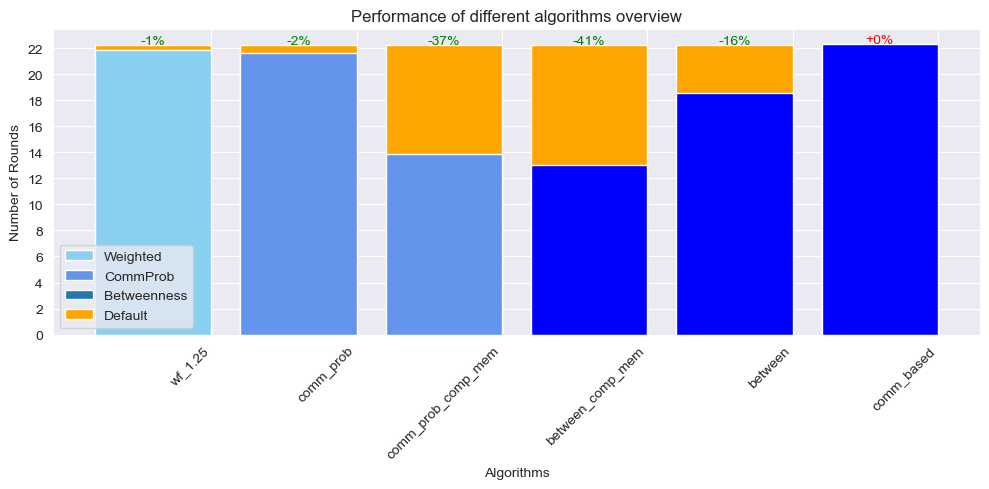

In [24]:
index = df_algorithm_means.index
numRounds = df_algorithm_means.numRounds

plot_performance(index, numRounds, 'overview', True)

In [25]:
# Calculate the mean for numeric columns in the group
numeric_means = dataframe.select_dtypes(include='number').mean()
# Drop NaN values from the Series
numeric_means = numeric_means.dropna()

# Now, average_values will contain the average values for each group
numeric_means

prior_partner_factor                     0.300000
assortativity                            0.236579
averageAuthorityScore                    0.001000
averageBetweennessCentrality             0.011189
averageClosenessCentrality               0.084828
averageCommunitySize                    34.998090
averageDegreeCentrality                  0.002341
averageEccentricity                     24.933898
averageEdgeDegree                        2.349911
averageEigenvectorCentrality             0.006641
averageHubScore                          0.001000
averageNearestNeighborsDegree            2.608177
averagePageRank                          0.001000
averagePathLength                       12.155649
averageRichClubCoefficient               0.032299
clusterCoefficient                       0.009759
density                                  0.002341
diameter                                35.402362
edgeConnectivity                         1.000000
estimatedPowerLawExponent               24.023413
